In [17]:
!ls

Logs  Users  projects


In [18]:
%cd /home/azureuser/cloudfiles/code/projects/BRATS_3D/

/mnt/batch/tasks/shared/LS_root/mounts/clusters/e4ds-v4/code/projects/BRATS_3D


# Loading Data

In [19]:
import os
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import nibabel as nib
from glob import glob
import numpy as np

from monai.transforms import (
    Compose, 
    ResizeD,
    NormalizeIntensityd, 
    RandFlipd,
    RandAffined,
    ToTensord,
)

from monai.data import Dataset as MonaiDataset

In [20]:
BASE_DIR = "./data"
TRAIN_DIR = os.path.join(BASE_DIR, "ASNR-MICCAI-BraTS2023-GLI-Challenge-TrainingData")

# As the Validataion masks were not released I am gonna split 80:20 on training data
# VAL_DIR = os.path.join(BASE_DIR, "ASNR-MICCAI-BraTS2023-GLI-Challenge-ValidationData")

In [21]:
class BraTSDataset(Dataset):
    '''
    This class is to load and convert .nii files to tensors
    '''
    def __init__(self, root, is_train=True):
        self.is_train = is_train
        self.cases = sorted([dir for dir in glob(os.path.join(root, "*")) if os.path.isdir(dir)])

    def __len__(self):
        return len(self.cases)
    
    def load_niifti(self, path):
        return nib.load(path).get_fdata().astype(np.float32)

    def __getitem__(self, idx):
        case = self.cases[idx]

        t1 = self.load_niifti(glob(os.path.join(case, "*-t1n.nii.gz"))[0])
        t1ce = self.load_niifti(glob(os.path.join(case, "*-t1c.nii.gz"))[0])
        t2 = self.load_niifti(glob(os.path.join(case, "*-t2w.nii.gz"))[0])
        flair = self.load_niifti(glob(os.path.join(case, "*-t2f.nii.gz"))[0])

        image = np.stack([t1, t1ce, t2, flair])
        image = torch.tensor(image)

        sample = {"image" : image}

        if self.is_train:
            seg = self.load_niifti(glob(os.path.join(case, "*-seg.nii.gz"))[0])
            sample["mask"] = torch.tensor(seg).unsqueeze(0)

        return sample

In [22]:
# defining ds 
full_train_ds = BraTSDataset(TRAIN_DIR, is_train=True)

# splitting 80/20
train_size = int(0.8 * len(full_train_ds))
val_size = len(full_train_ds) -  train_size

In [23]:
# Transformations & loaders
total = len(full_train_ds)
train_count = int(0.8 * total)
val_count = total - train_count

train_ds_raw, val_ds_raw = random_split(full_train_ds, [train_count, val_count])

# MONAI transforms
train_transform = Compose([
    ResizeD(keys=["image"], spatial_size=(128, 128, 160), mode="trilinear"),
    ResizeD(keys=["mask"], spatial_size=(128, 128, 160), mode="nearest"),
    NormalizeIntensityd(keys=["image"]),
    RandFlipd(keys=["image", "mask"], prob=0.5, spatial_axis=0),
    RandAffined(
        keys=["image", "mask"],
        prob=0.3,
        rotate_range=(0, 0, 0.2),
        mode=["trilinear", "nearest"]
    ),
    ToTensord(keys=["image", "mask"]),
])

val_transform = Compose([
    ResizeD(keys=["image"], spatial_size=(128, 128, 160), mode="trilinear"),
    ResizeD(keys=["mask"], spatial_size=(128, 128, 160), mode="nearest"),
    NormalizeIntensityd(keys=["image"]),
    ToTensord(keys=["image", "mask"]),
])

# Wrap into MONAI datasets with transforms
train_ds = MonaiDataset(data=train_ds_raw, transform=train_transform)
val_ds = MonaiDataset(data=val_ds_raw, transform=val_transform)

# DataLoaders
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=4)
val_loader = DataLoader(val_ds, batch_size=1, shuffle=False, num_workers=4)



## Sanity check across dataset

In [7]:
# Checking patterns accross Dataset
def check_brats_files(root):
    required_patterns = {
        "t1": "*-t1n.nii.gz",
        "t1ce": "*-t1c.nii.gz",
        "t2": "*-t2w.nii.gz",
        "flair": "*-t2f.nii.gz",
        "seg": "*-seg.nii.gz"
    }

    cases = sorted([dir for dir in glob(os.path.join(root, "*")) if os.path.isdir(dir)])
    missing_report = []

    for case in cases:
        for key, pattern, in required_patterns.items():
            files = glob(os.path.join(case, pattern))

            if len(files) == 0:
                missing_report.append((case, key, pattern))
    
    if missing_report:
        print("Missing files detected:\n")
        for case, key, pattern in missing_report:
            print(f"Case: {os.path.basename(case)} | Missing: {key} | Pattern: {pattern}")
    else:
        print("All files exist for all cases!")

In [8]:
print("Checking Train DS")
check_brats_files(TRAIN_DIR)

Checking Train DS
All files exist for all cases!


# Understanding & Visualizing the BraTS dataset

In [24]:
print(f"Train_len: {len(train_ds)}, Val_len: {len(val_ds)}")

Train_len: 1000, Val_len: 251


In [25]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

In [26]:
# selecting one sample from ds
sample = next(iter(train_loader))
samp_image = sample["image"]
modalities = ["T1", "T1CE", "T2", "FLAIR"]

samp_mask = sample["mask"]
samp_mask.shape

torch.Size([1, 1, 128, 128, 160])

In [27]:
samp_image = samp_image.squeeze(0)
samp_mask = samp_mask.squeeze(0).squeeze(0)
print(samp_image.shape, samp_mask.shape) 

torch.Size([4, 128, 128, 160]) torch.Size([128, 128, 160])


In [28]:
for i in range(samp_image.shape[0]):
    print(f"Modalities: {modalities[i]},  MIN: {samp_image[i].min().item()}, MAX: {samp_image[i].max().item()}")

Modalities: T1,  MIN: -0.3928927183151245, MAX: 3.821594715118408
Modalities: T1CE,  MIN: -0.3928927183151245, MAX: 8.512678146362305
Modalities: T2,  MIN: -0.3928927183151245, MAX: 10.019667625427246
Modalities: FLAIR,  MIN: -0.3928927183151245, MAX: 3.4084880352020264


In [29]:
samp_mask.unique()
# samp_mask.shape

metatensor([0., 1., 2., 3.])

## Visualizing certain slice

In [15]:
# picking the image from the middle of the 3D tensor
slice_idx = samp_image.shape[-1] // 2

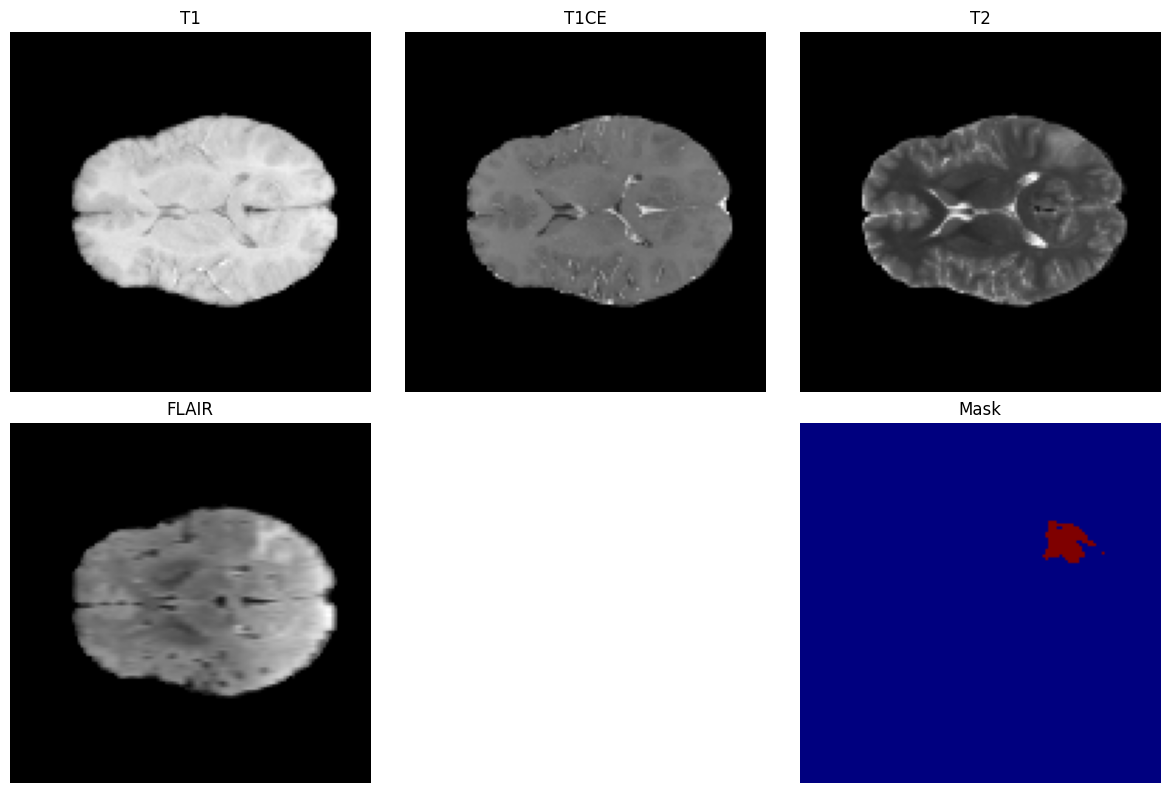

In [16]:
# defining the modalities of the stack
modalities = ["T1", "T1CE", "T2", "FLAIR"]

plt.figure(figsize=(12, 8))

for i in range(4):
    plt.subplot(2, 3, i+1)
    plt.title(modalities[i])
    plt.imshow(samp_image[i, :, :, slice_idx], cmap="gray")
    plt.axis("off")

plt.subplot(2, 3, 6)
plt.title("Mask")
plt.imshow(samp_mask[:, :, slice_idx], cmap="jet")
plt.axis("off")

plt.tight_layout()
plt.show()


## Visualizing certain modalities

In [30]:
%matplotlib widget

In [31]:
# Checking shape compatibility
samp_mask.shape == samp_image.shape[1:]

True

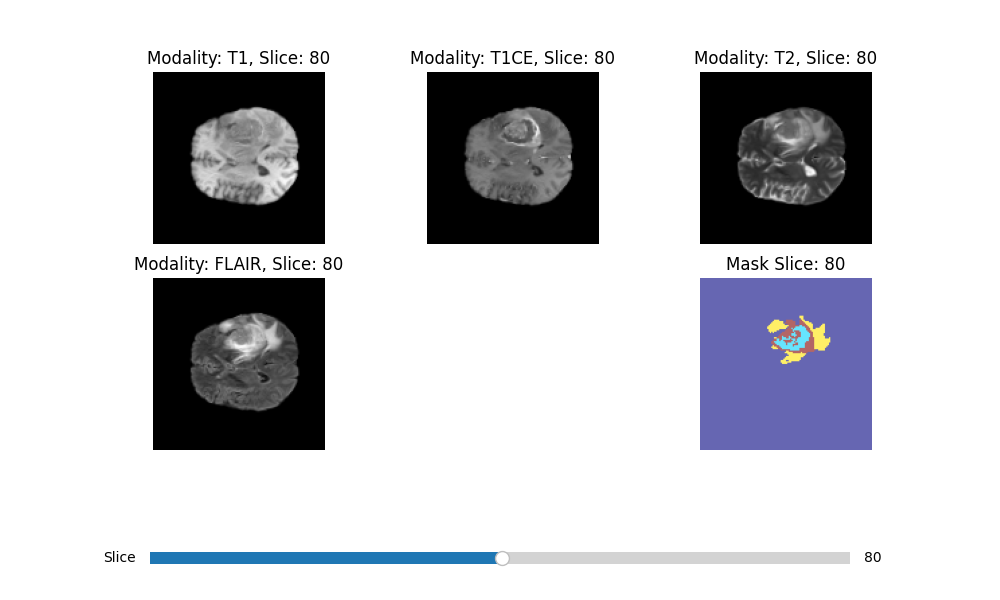

In [33]:
# Visualizing with slider
H, W, D = samp_image.shape[1:]

init_slice = D // 2

fig, axes = plt.subplots(2, 3, figsize=(10, 6))
plt.subplots_adjust(bottom=0.25)

axes = axes.flatten()

displays = []

# Display initial image across modalities
for i in range(4):
    ax = axes[i]
    img_disp = ax.imshow(samp_image[i, :, :, init_slice], cmap="gray")
    ax.set_title(f"Modality: {modalities[i]}, Slice: {init_slice}")
    ax.axis("off")
    displays.append(img_disp)

mask_ax = axes[5]
mask_disp = mask_ax.imshow(samp_mask[:, :, init_slice], cmap="jet", alpha=0.6)
mask_ax.set_title(f"Mask Slice: {init_slice}")
mask_ax.axis("off")
displays.append(mask_disp)

axes[4].axis("off")  # empty subplot

# slider axis
ax_slider = plt.axes([0.15, 0.05, 0.7, 0.04])
slice_slider = Slider(ax_slider, "Slice", 0, D-1, valinit=init_slice, valfmt='%d')

def update(val):
    slice_idx = int(slice_slider.val)
    for i in range(4):
        displays[i].set_data(samp_image[i, :, :, slice_idx])
        axes[i].set_title(f"Modality: {modalities[i]}, Slice: {slice_idx}")
    
    displays[4].set_data(samp_mask[:, :, slice_idx])
    axes[5].set_title(f"Mask Slice: {slice_idx}")
    # fig.canvas.draw_idle()

slice_slider.on_changed(update)
plt.show()



In [22]:
# Checking unique values in a particular slice of the mask (Me being skeptical)
print(samp_mask[:, :, 50].unique())
print(samp_mask[:, :, 65].unique())
print(samp_mask[:, :, 81].unique())
print(samp_mask[:, :, 120].unique())
print(samp_mask[:, :, 127].unique())

metatensor([0.])
metatensor([0.])
metatensor([0., 2.])
metatensor([0., 1., 2., 3.])
metatensor([0., 2., 3.])


# Model Implementation (SwinUNETR)

In [6]:
from monai.networks.nets import SwinUNETR
from monai.losses import DiceCELoss
from monai.metrics import DiceMetric
from monai.data import decollate_batch
from monai.transforms import AsDiscrete

from torch.amp import autocast, GradScaler
from torch.utils.tensorboard import SummaryWriter

In [9]:
def train_swinunetr(model, train_loader, val_loader, num_classes, n_epochs=100, lr=1e-4, weight_decay=1e-5, val_interval=2, device="cpu", ckpt_path=None):
    
    loss_fn = DiceCELoss(include_background=False, to_onehot_y=True, softmax=True)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    scaler = GradScaler()

    dice_metric = DiceMetric(include_background=False, reduction="mean")

    post_pred = AsDiscrete(argmax=True, to_onehot=num_classes)
    post_label = AsDiscrete(to_onehot=num_classes)

    writer = SummaryWriter()

    for epoch in range(n_epochs):
        print(f"Starting epoch {epoch+1}/{n_epochs}")
        print("-" * 30)
        model.train()

        epoch_loss = 0

        for batch in train_loader:
            images = batch["image"].to(device)
            labels = batch["mask"].to(device)

            optimizer.zero_grad()


            with autocast(device_type=device.type):
                output = model(images)
                loss = loss_fn(output, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            epoch_loss += loss.item()
        
        epoch_loss /= len(train_loader)
        writer.add_scalar("Train/Loss", epoch_loss, epoch)
        print(f"Epoch {epoch+1}/{n_epochs}, Train Loss: {epoch_loss}")

        # Validataion
        if ((epoch + 1) % val_interval) == 0:
            model.eval()
            dice_scores = []

            with torch.no_grad():
                for batch in val_loader:
                    images = batch["image"].to(device)
                    labels = batch["mask"].to(device)

                    with autocast(device_type=device.type):
                        output = model(images)

                    output = [post_pred(i) for i in decollate_batch(output)]
                    labels = [post_label(i) for i in decollate_batch(labels)]

                    dice_metric(y_pred=output, y=labels)

                    dice_scores.append(dice_metric.aggregate().item())
                    dice_metric.reset()
            mean_dice = sum(dice_scores) / len(dice_scores)

            writer.add_scalar("Val/Mean_Dice", mean_dice, epoch)
            print(f"Epoch {epoch+1}/{n_epochs}, Validation Mean Dice: {mean_dice}")
            print("---" * 30, end="\n")

            if ckpt_path:
                torch.save(model.state_dict(), f"{ckpt_path}/epoch_{epoch+1}_dice_{mean_dice:.4f}.pth")

    writer.close()
    return model

                

In [10]:
# device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# model Initialization
model = SwinUNETR(
    in_channels=4,
    out_channels=4,
    feature_size=48,
    use_checkpoint=True,
    ).to(device)

trained_model = train_swinunetr(
    model, 
    train_loader, 
    val_loader, 
    num_classes=4,
    n_epochs=50, 
    val_interval=1,
    device=device, 
    ckpt_path="./weights"
    )

Starting epoch 1/2
------------------------------
Epoch 1/2, Train Loss: 1.0717572270929814
Epoch 1/2, Validation Mean Dice: 0.5022855038008842
------------------------------------------------------------------------------------------
Starting epoch 2/2
------------------------------
Epoch 2/2, Train Loss: 0.5641376551389694
Epoch 2/2, Validation Mean Dice: 0.5988026028907156
------------------------------------------------------------------------------------------
